# Reinforcement Learning Final Project 

Welcome to your Reinforcement Learning project focused on developing an RL agent capable of playing chess at a strategic level. Chess has long been considered a benchmark for measuring AI capabilities, and this project aims to leverage the power of RL to create an intelligent agent that can make optimal decisions in complex chess positions. By combining the principles of reinforcement learning with the rich strategic domain of chess, you will explore new approaches to create the most effective chess player.

## Project Objectives:

* Train an RL agent to play chess: The primary objective of this project is to develop an RL agent that can play chess at a high level of proficiency. The agent should be capable of evaluating chess positions and making strategic decisions.

* Optimize decision-making using RL algorithms: Explore different RL algorithms, as seen in class, to train the agent. Compare and analise their effectiveness in learning and decision-making capabilities in the context of chess.

* Use a challenging chess environment: Use a comprehensive environment for the agent to interact with, representing the rules and dynamics of chess. This environment will provide a realistic and challenging setting for the agent's training and evaluation.

* Evaluate and benchmark performance: Assess the performance of the RL agent against different benchmarks from existing chess engines. You will compare your agent's performance to established chess engines to measure progress and identify areas for improvement.


### Extra Objectives:

* Investigate transfer learning and generalization: Explore techniques for transfer learning to leverage knowledge acquired in related domains or from pre-training on large chess datasets. Investigate the agent's ability to generalize its knowledge.

* Enhance interpretability and analysis: Develop methods to analise the agent's decision-making process and provide insights into its strategic thinking. Investigate techniques to visualize the agent's evaluation of chess positions and understand its reasoning behind specific moves.

## Let's Play Chess! 

As you know [Chess](https://en.wikipedia.org/wiki/Chess) is a board game for two players, called White and Black, each controlling an army of chess pieces in their color, with the objective to checkmate the opponent's king.

Chess is an abstract strategy game that involves no hidden information and no use of dice or cards. It is played on a chessboard with 64 squares arranged in an eight-by-eight grid. At the start, each player controls sixteen pieces: one king, one queen, two rooks, two bishops, two knights, and eight pawns. White moves first, followed by Black. Checkmating the opponent's king involves putting the king under immediate attack (in "check") whereby there is no way for it to escape.


![](Images/CHESS_MOVES.PNG)

* The king moves one square in any direction. There is also a special move called castling that involves moving the king and a rook. The king is the most valuable piece — attacks on the king must be immediately countered, and if this is impossible, the game is immediately lost.
* A rook can move any number of squares along a rank or file, but cannot leap over other pieces. Along with the king, a rook is involved during the king's castling move.
* A bishop can move any number of squares diagonally, but cannot leap over other pieces.
* A queen combines the power of a rook and bishop and can move any number of squares along a rank, file, or diagonal, but cannot leap over other pieces.
* A knight moves to any of the closest squares that are not on the same rank, file, or diagonal. (Thus the move forms an "L"-shape: two squares vertically and one square horizontally, or two squares horizontally and one square vertically.) The knight is the only piece that can leap over other pieces.
* A pawn can move forward to the unoccupied square immediately in front of it on the same file, or on its first move it can advance two squares along the same file, provided both squares are unoccupied (black dots in the diagram). A pawn can capture an opponent's piece on a square diagonally in front of it by moving to that square (black crosses). It cannot capture a piece while advancing along the same file. A pawn has two special moves: the en passant capture and promotion.

## The [Environment](https://github.com/iamlucaswolf/gym-chess)

The environment gym-chess provides OpenAI Gym environments for the game of Chess. It comes with an implementation of the board and move encoding used in AlphaZero. 

Please install it using the command: 

`pip install gym-chess`

In [1]:
#from stockfish import Stochfish
#ver como fazer isto

In [2]:
#pip install gym-chess

In [3]:
import chess
import gym
import gym_chess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import copy
from typing import Optional
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import cv2
import time
import chess.pgn
import io

from IPython.display import clear_output, display
import torch
import torch.nn as nn
import sys
import torch.nn.functional as F

In [4]:
#!pip install --upgrade numpy

### A Two player's game

As you know chess is played by two players, as such the gym-chess environment gives you access to both players actions in a sequential matter.

In [5]:
def WHITE_PLAYER_POLICY(env, state):
    legal_actions = env.legal_actions
    action = np.random.choice(legal_actions)

    return action


def BLACK_PLAYER_POLICY(env, state):
    legal_actions = env.legal_actions
    action = np.random.choice(legal_actions)

    return action

In [6]:
env = gym.make(
    "ChessAlphaZero-v0"
)  # We will use Alpha Zero's numenclature for the actions encodings

state = env.reset()
done = False
counter = 0  # Since each step represents a play in a chess game we are going to store the number of steps associated to the episode/game

while not done:
    if (
        counter % 2 == 0
    ):  # If the step number is pair, this means that it is the WHITE player's turn
        action = WHITE_PLAYER_POLICY(env, state)
        next_state, reward, done, info = env.step(action)

    else:  # If the step number is not pair, aka odd, this means that it is the BLACK player's turn
        action = BLACK_PLAYER_POLICY(env, state)
        next_state, reward, done, info = env.step(action)

    counter += 1

print(reward)

env.close()


-1.0


#### The agent receives a reward of +1 when the white player makes a winning move, and a reward of -1 when the black player makes a winning move. 

All other rewards are zero.

### Evaluationg your agent with [Stockfish](https://github.com/zhelyabuzhsky/stockfish)

In order to have a good enough idea that our agent is actually playing well we need a benchmarkable opponent.

As such we need to install stockfish a free and open-source chess engine. Stockfish has consistently ranked first or near the top of most chess-engine rating lists and, as of April 2023, is the strongest CPU chess engine in the world.

`pip install stockfish`


In [7]:
#!pip install stockfish

In [8]:
from stockfish import Stockfish

StockFish has a python api as seen above, nevertheless the engine still needs to be downloaded [here](https://stockfishchess.org/download/) and used in the path.

NOTE: You were given an engine already in moodle, nevertheless different computer systems (Windows, Mac, Ubuntu) might require other Stockfish engines.

In [9]:
Stockfish_path = "C:/Users/isabe/Desktop/RL/Project/stockfish_15.1_win_x64_avx2/stockfish-windows-2022-x86-64-avx2"

The functions bellow generate episodes/games for a WHITE or BLACK Pieces Scenario respectively. We store the outcome of the episode (win/draw/loss) and the number of steps taken.

#### Notice how the AGENT_POLICY function is used it recieves as inputs the env and the current state.
`action = AGENT_POLICY(env, state)`

In [10]:
def generate_WHITE_scenario(Stockfish_path, AGENT_POLICY):
    env = gym.make(
        "ChessAlphaZero-v0"
    )  # We will use Alpha Zero's numenclature for the actions encodings
    stockfish = Stockfish(Stockfish_path)
    stockfish.set_elo_rating(
        100
    )  # Default "skill" level is 1350, higher will increase the skill of stockfish "player". See more at https://en.wikipedia.org/wiki/Elo_rating_system

    state = env.reset()
    done = False
    counter = 0  # Since each step represents a play in a chess game we are going to store the number of steps associated to the episode/game

    while not done:
        if (
            counter % 2 == 0
        ):  # If the step number is pair, this means that it is the WHITE player's turn
            action = AGENT_POLICY(env, state)
            decoded_action = str(env.decode(action))
            stockfish.make_moves_from_current_position([decoded_action])
            next_state, reward, done, info = env.step(action)

        else:  # If the step number is not pair, aka odd, this means that it is the BLACK player's turn
            decoded_action = stockfish.get_best_move()
            action = env.encode(chess.Move.from_uci(decoded_action))
            stockfish.make_moves_from_current_position([decoded_action])
            next_state, reward, done, info = env.step(action)

        counter += 1

    env.close()

    return reward, np.ceil(counter / 2), state


def generate_BLACK_scenario(Stockfish_path, AGENT_POLICY):
    env = gym.make(
        "ChessAlphaZero-v0"
    )  # We will use Alpha Zero's numenclature for the actions encodings
    stockfish = Stockfish(Stockfish_path)
    stockfish.set_elo_rating(
        100
    )  # Default "skill" level is 1350, higher will increase the skill of stockfish "player". See more at https://en.wikipedia.org/wiki/Elo_rating_system

    state = env.reset()
    done = False
    counter = 0  # Since each step represents a play in a chess game we are going to store the number of steps associated to the episode/game

    while not done:
        if (
            counter % 2 == 1
        ):  # If the step number is not pair, aka odd, this means that it is the BLACK player's turn
            action = AGENT_POLICY(env, state)
            decoded_action = str(env.decode(action))
            stockfish.make_moves_from_current_position([decoded_action])
            next_state, reward, done, info = env.step(action)

        else:  # If the step number is pair, this means that it is the WHITE player's turn
            decoded_action = stockfish.get_best_move()
            action = env.encode(chess.Move.from_uci(decoded_action))
            stockfish.make_moves_from_current_position([decoded_action])
            next_state, reward, done, info = env.step(action)

        counter += 1

    env.close()

    return reward, np.ceil(counter / 2), state

In the function bellow a visualization is produced from the bechmarks made.

In [11]:
def AGENT_EVALUATION(Stockfish_path, AGENT_POLICY, n_evaluations=100):
    results_list = []

    for evaluation_number in tqdm(range(n_evaluations)):
        generate_episode = generate_WHITE_scenario

        reward, n_steps = generate_episode(Stockfish_path, AGENT_POLICY)

        if reward == 1:
            result = "VICTORY"
        elif reward == 0:
            result = "DRAW"
        else:
            result = "LOSS"

        results_list.append(["WHITE", result, n_steps])

        generate_episode = generate_BLACK_scenario

        reward, n_steps = generate_episode(Stockfish_path, AGENT_POLICY)

        if reward == -1:
            result = "VICTORY"
        elif reward == 0:
            result = "DRAW"
        else:
            result = "LOSS"

        results_list.append(["BLACK", result, n_steps])

    df = pd.DataFrame(
        results_list, columns=["AGENT COLOR", "OUTCOME", "N STEPS"]
    ).astype("int", errors="ignore")

    plt.style.use("fivethirtyeight")

    results_group = (
        df.groupby(["AGENT COLOR", "OUTCOME"])
        .count()
        .rename(columns={"N STEPS": "GAMES"})
    )

    n_games = results_group.sum()[0]

    results_group = (2 * 100 * results_group / (n_games)).astype("int")

    viz_df = (
        results_group.reset_index()
        .pivot_table(index="AGENT COLOR", columns="OUTCOME", values="GAMES")
        .fillna(0)
    )

    viz_df.plot(kind="barh", stacked=True)

    plt.xlabel("Percentage")
    plt.title(f"EVALUATION RESULTS FOR {n_games} GAMES")

    plt.show()

    return df

  0%|          | 0/5 [00:00<?, ?it/s]

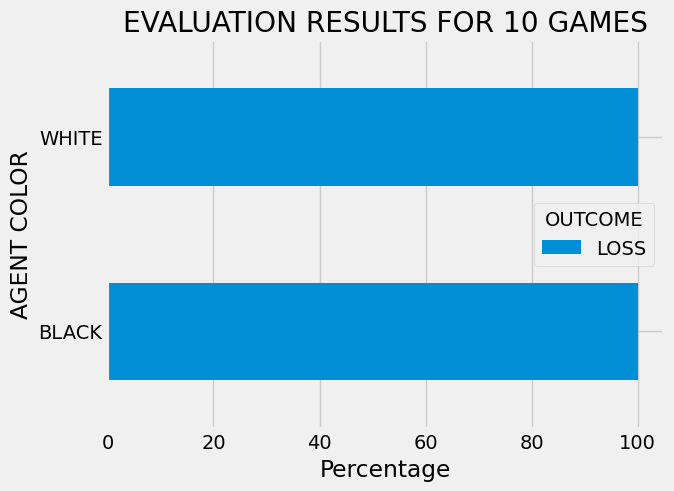

In [11]:
df = AGENT_EVALUATION( WHITE_PLAYER_POLICY, n_evaluations=5)

In [ ]:
df.head(5)

# Ready to Play Chess?

In [12]:
# Set the seed for NumPy
np.random.seed(42)

# Set the seed for TensorFlow
tf.random.set_seed(42)

#set seed for random
random.seed(42)

# Set the seed for TensorFlow
torch.manual_seed(42)


# Monte Carlo Tree Search (MCTS)

In [13]:
white_pieces={0: "pawn", 1: "horse", 2: "knight", 3: "rook", 4: "queen", 5: "king"}
black_pieces={6: "pawn", 7: "horse", 8: "knight", 9: "rook", 10: "queen", 11: "king"}

In [14]:
def AGENT_EVALUATION(Stockfish_path, AGENT_POLICY, n_evaluations=100):
    results_list = []

    for evaluation_number in tqdm(range(n_evaluations)):
        print(evaluation_number)
        generate_episode = generate_WHITE_scenario
        reward, n_steps, last_state = generate_episode(Stockfish_path, AGENT_POLICY)

        if reward == 1:
            result = "VICTORY"
        elif reward == 0:
            result = "DRAW"
        else:
            result = "LOSS"

        agent_pieces = last_state[:, :,6:13].sum()
        opponent_pieces = last_state[:, :,:6].sum()
        remaining_pieces=[]
        for piece in white_pieces: #PARA TODOS
            remaining_pieces.append(last_state[:,:,piece].sum()) #PARA TODOS: podem ter de ajustar para [:, :,piece]
        results_list.append(["WHITE", result, n_steps, agent_pieces, opponent_pieces, *remaining_pieces]) #PARA TODOS
        

        generate_episode = generate_BLACK_scenario
        reward, n_steps, last_state = generate_episode(Stockfish_path, AGENT_POLICY)

        if reward == -1:
            result = "VICTORY"
        elif reward == 0:
            result = "DRAW"
        else:
            result = "LOSS"

        agent_pieces = last_state[:, :,6:13].sum() 
        opponent_pieces = last_state[:, :,:6].sum()
        remaining_pieces=[] #PARA TODOS
        for piece in black_pieces: #PARA TODOS
            remaining_pieces.append(last_state[:,:,piece].sum()) #PARA TODOS: podem ter de ajustar para [:, :,piece]
        results_list.append(["BLACK", result, n_steps, agent_pieces, opponent_pieces, *remaining_pieces]) #PARA TODOS

    df = pd.DataFrame(
        results_list, columns=["AGENT COLOR", "OUTCOME", "N STEPS", "AGENT PIECES", "OPPONENT PIECES", "pawn", "horse", "knight", "rook", "queen", "king"]
    ).astype("int", errors="ignore")

    plt.style.use("fivethirtyeight")

    results_group = (
        df.groupby(["AGENT COLOR", "OUTCOME"])
        .count()
        .rename(columns={"N STEPS": "GAMES"})
    )

    n_games = results_group.sum()[0]

    results_group = (2 * 100 * results_group / (n_games)).astype("int")

    viz_df = (
        results_group.reset_index()
        .pivot_table(index="AGENT COLOR", columns="OUTCOME", values="GAMES")
        .fillna(0)
    )

    viz_df.plot(kind="barh", stacked=True)

    plt.xlabel("Percentage")
    plt.title(f"EVALUATION RESULTS FOR {n_games} GAMES")

    plt.show()

    return df


  0%|          | 0/1 [00:00<?, ?it/s]

0


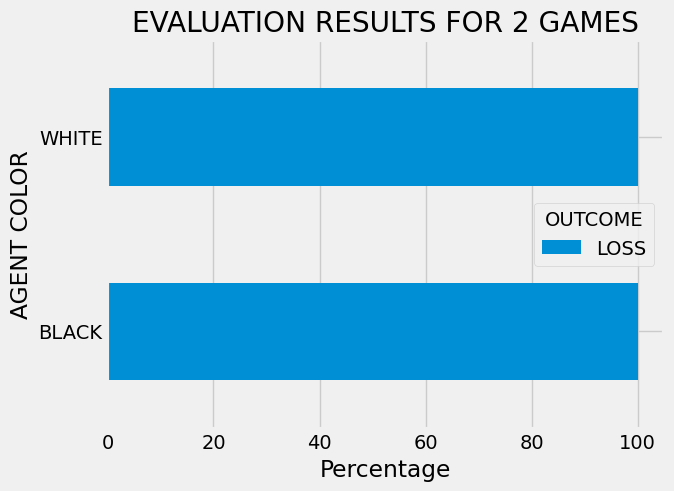

In [15]:
def traverse(node):
    while node.done:
        node = node.select_child()
        if node is None:
            return None
    return node.expand()

def rollout(node):
    current_node = node
    done = False
    while current_node is not None:
        if done:
            break

        legal_actions = list(current_node.env.legal_actions)
        action = random.choice(legal_actions)
        next_state, reward, done, info = current_node.env.step(action)
        new_node = Node(state=next_state, env=current_node.env, done=done, parent=current_node, action=action)
        current_node.children[action] = new_node
        current_node = new_node

    return reward


def backpropagate(leaf_node, reward):
    current_node = leaf_node
    while current_node is not None:
        current_node.visits += 1
        current_node.total_reward += reward
        current_node = current_node.parent

def MCTS(root, iterations):
    for _ in range(iterations):
        leaf = traverse(root)
        if leaf is not None:
            simulation_result = rollout(leaf)
            backpropagate(leaf, simulation_result)
    
    #Save the root node (and by extension, the entire MCTS tree) to a file
    
    #with open('mcts_tree.pickle', 'wb') as handle:
    #    pickle.dump(root, handle, protocol=pickle.HIGHEST_PROTOCOL)

    if len(root.children) == 0:
        return None
    return root.best_child().action


class Node:
    def __init__(self, state, env, done, parent=None, action=None):
        self.state = state
        self.env = env
        self.done = done
        self.parent = parent
        self.children = {}
        self.visits = 0
        self.total_reward = 0
        self.action = action

    def is_fully_expanded(self):
        return len(self.children) == len(self.env.legal_moves)

    def select_child(self):
        s = sorted(self.children.items(), key = lambda child: child[1].get_value())
        return s[-1][1]

    def expand(self):
        legal_actions = list(self.env.legal_moves)
        if len(legal_actions) == 0:
            return None
        move = np.random.choice(legal_actions)
        action = self.env.encode(move) 
        new_env = copy.deepcopy(self.env)
        if move in new_env.legal_moves:
            next_state, _, done, _ = new_env.step(action)  
            new_child = Node(state=next_state, env=new_env,done=done, parent=self, action=action)
            self.children[action] = new_child
            return new_child
        return None

            
    def take_action(self, action):
        new_env = self.env.clone()
        new_env.step(action)
        return Node(state=new_env.state(), env=new_env, parent=self, action=action)

    def calculate_reward(self):
        return self.env.reward()  

    def get_value(self):
        if self.visits == 0:
            return 0
        else:
            return self.total_reward / self.visits + np.sqrt(2 * np.log(self.parent.visits) / self.visits)

    def best_child(self):
        if not self.children:
            return None
        s = sorted(self.children.items(), key=lambda child: child[1].get_value())
        return s[-1][1]

def WHITE_PLAYER_POLICY(env, state):
    root = Node(state=state, env=env, done= False)
    action = MCTS(root, 1)
    return action

df = AGENT_EVALUATION(Stockfish_path, WHITE_PLAYER_POLICY, n_evaluations=1)

In [57]:
df.head(10)

,AGENT COLOR,OUTCOME,N STEPS,AGENT PIECES,OPPONENT PIECES,EPISODE,pawn,horse,knight,rook,queen,king
0,WHITE,LOSS,13,15,12,0,6,2,1,2,0,1
1,BLACK,LOSS,16,8,16,0,8,2,2,2,1,1
2,WHITE,LOSS,21,13,10,1,6,1,1,1,0,1
3,BLACK,LOSS,22,12,15,1,7,2,2,2,1,1
4,WHITE,LOSS,27,13,4,2,3,0,0,0,0,1
5,BLACK,LOSS,14,12,16,2,8,2,2,2,1,1
6,WHITE,LOSS,18,14,10,3,5,1,1,2,0,1
7,BLACK,LOSS,18,12,16,3,8,2,2,2,1,1
8,WHITE,LOSS,29,13,6,4,4,0,1,0,0,1
9,BLACK,LOSS,16,9,15,4,7,2,2,2,1,1


The results from the MCTS were the following:


![](Images/outcome_MCTS.PNG)

# Deep SARSA

The first step in SARSA is to initialize  the Q-values. However the chess is very complex, so we will be using a QNetwork

In [34]:
#this neural network will aproximate the q-values for our SARSA
class QNetwork(nn.Module):
    def __init__(self, state , output_size):
        self.output_size = output_size
        super(QNetwork, self).__init__()
        self.x_layer = nn.Linear(119, 150)
        self.h_layer = nn.Linear(150, 120)
        self.y_layer = nn.Linear(120, output_size)
        #print(output_size)
        

    def forward(self, state):
        xh = F.relu(self.x_layer(state))
        hh = F.relu(self.h_layer(xh))
        state_action_values = self.y_layer(hh)
        return state_action_values.view(-1, self.output_size)

Creation of agent class to make policy and update network

In [35]:
# this class will be our agent

class SARSAAgent(object):
    def __init__(self, state, action_dim, env):
        #initialize variables for the sarsa agent
        self.qnet = QNetwork(state, action_dim)
        self.qnet_optim = torch.optim.Adam(self.qnet.parameters(), lr=0.001)
        self.gamma = 0.9
        self.MSELoss_function = nn.MSELoss()
        self.replay_buffer = ReplayBuffer()
        self.env=env
        pass
    
    # this is our SARSA policy, e-greed
    def SARSA_POLICY(self, env, state, epsilon):

        if np.random.uniform(0, 1) < epsilon:
                legal_actions = env.legal_actions
                return np.random.choice(legal_actions)  # choose random action
        else:
                state_tensor = torch.from_numpy(state).float() #transfor state into tensor so we are able to  input it
                network_output = self.qnet(state_tensor) #predict the qualues for this state
                reshaped_output = network_output[0] # choosing only the dimension that we want
                #print(reshaped_output.shape)
                legal_q_values= reshaped_output[env.legal_actions] #choose only the legal actions
                return env.legal_actions[np.argmax(legal_q_values.detach().numpy())]  # choose greedy action
        
    def update_Sarsa_Network(self, state, next_state, action, next_action, reward, terminals, alpha=.85):
        #obtaining the current Q-values for all the possible action in the the next_state
        qsa = torch.gather(self.qnet(state), dim=1, index=action.long())
        #next_state = torch.sum(input_tensor, dim=(1, 2, 3))
        qsa_next_action = torch.gather(self.qnet(next_state), dim=1, index=next_action.long())
        #not_terminals = 1 - terminals
        qsa_next_target = qsa + alpha*(reward  + (self.gamma * qsa_next_action-qsa))
        q_network_loss = self.MSELoss_function(qsa_next_action, qsa_next_target.detach()) 
        #initializes the gradients of the Q-network parameters to zero
        self.qnet_optim.zero_grad()
        q_network_loss.backward() #backpropagation
        self.qnet_optim.step() #updates the Q-network parameters
        
    #The purpose of this code is to update the SARSA network using a specified number of iterations (update_rate). 
    #In each iteration, a minibatch of transitions is sampled from a replay buffer, and the network is updated using the update_Sarsa_Network method.  
    def update_s(self, update_rate):
        for i in range(update_rate):
            states, next_states, actions, next_actions, rewards, terminals = self.replay_buffer.sample_minibatch_sarsa(64) #minibatch iniatilization
            #variables preparation for updating the network
            states = torch.Tensor(states)
            next_states = torch.Tensor(next_states)
            actions = torch.Tensor(actions)

            #environment crition to be able to decode moves for the next_actions
            second_env =  gym.make("ChessAlphaZero-v0")
            second_env.reset()
            #print(next_actions)
            next_actions = torch.Tensor([[self.env.encode(chess.Move.from_uci(move[0]))] if isinstance(move[0], str) else [move[0]] for move in next_actions])
            rewards = torch.Tensor(rewards)
            terminals = torch.Tensor(terminals)
            second_env.close()
            #print(states.shape, actions.shape)
            #print(next_states.shape, next_actions.shape)
            #call the network update
            self.update_Sarsa_Network(states, next_states, actions, next_actions, rewards, terminals)
            

A replay buffer is used in reinforcement learning algorithms to store and sample experiences for training the agent. 

In [36]:
class ReplayBuffer(object):
    def __init__(self):
        self.buffer = []
        self.buffer_s = []
    
    #data storing
    def add_to_buffer_sarsa(self, data):
        #data must be of the form (state,next_state,action,n_action,reward,terminal)
        self.buffer_s.append(data)

    #define sample of minibach
    def sample_minibatch_sarsa(self,minibatch_length):
        states = []
        next_states = []
        actions = []
        next_actions = []
        rewards = []
        terminals = []
        for i in range(minibatch_length):
            random_int = np.random.randint(0, len(self.buffer_s)-1) 
            transition = self.buffer_s[random_int]
            states.append(transition[0])
            next_states.append(transition[1])
            actions.append(transition[2])
            next_actions.append(transition[3])
            rewards.append(transition[4])
            terminals.append(transition[5])
        return states, next_states, actions, next_actions, rewards, terminals

Create the functions to play the game

In [37]:
def generate_WHITE_SARSA(Stockfish_path, agent, epsilon):
    #variables creation
    env = gym.make("ChessAlphaZero-v0")  # We will use Alpha Zero's numenclature for the actions encodinng
    stockfish = Stockfish(Stockfish_path)
    stockfish.set_elo_rating(100) 
    counter = 0 
    done = False
    final_reward = 0
    
    #initialize the state by resetting the environment
    state = env.reset()

    #for each step in the episode:
    while not done:
        #print('counter', counter)
        if (counter % 2 == 0): #if pair then it is white's turn
            action= agent.SARSA_POLICY(env, state, epsilon)
            decoded_action = str(env.decode(action))
            stockfish.make_moves_from_current_position([decoded_action]) 
                
            #perform the selected action and store the next state information: 
            next_state, reward, done, info = env.step(action)

            #if the next state is not the terminal one
            if not done:
                next_action= agent.SARSA_POLICY(env, next_state, epsilon) #get the next best action by sarsa
                #print('next_Actionss', type(next_action))
                #add the data to the buffer
                agent.replay_buffer.add_to_buffer_sarsa((state, next_state, [action], [next_action], [reward],[done]))

            #if player removed piece from opponent, increase reward
            if next_state[:,:, :6].sum() < state[:,:, :6].sum(): 
                reward += 0.01
            
            #add the reward to the final reward
            final_reward += reward
            #print(done)

        else:  
            # If the step number is not pair, aka odd, this means that it is the BLACK player's turn
            decoded_action = stockfish.get_best_move()
            action = env.encode(chess.Move.from_uci(decoded_action))
            stockfish.make_moves_from_current_position([decoded_action])

            #perform the selected action and store the next state information: 
            next_state, reward, done, info = env.step(action)

            #if the next state is not the terminal one
            if not done:
                next_action = stockfish.get_best_move()
                #print('next_Action st', type(next_action))
                #update data for minibatch
                agent.replay_buffer.add_to_buffer_sarsa((state, next_state, [action], [next_action], [reward],[done]))
            #print(done)

        #if the current state is the terminal state then break:
        if done:
            break


        counter += 1
        state = next_state #update next action to current action

    agent.update_s(32) #update network
    
    #update epsilon
    if epsilon > 0.2:
        epsilon *= 0.995
    
    if epsilon <= 0.2:
        epsilon = 0.2


    env.close()
    print('Return:', final_reward, 'Steps:', counter, 'Epsilon:', epsilon)
    

    return final_reward, np.ceil(counter / 2), epsilon, state


def generate_BLACK_SARSA(Stockfish_path, agent, epsilon):
    #variables creation
    env = gym.make("ChessAlphaZero-v0")  # We will use Alpha Zero's numenclature for the actions encodinng
    stockfish = Stockfish(Stockfish_path)
    stockfish.set_elo_rating(100) 
    counter = 0 
    done = False
    final_reward = 0
    
    #initialize the state by resetting the environment
    state = env.reset()

    #for each step in the episode:
    while not done:
        if (counter % 2 == 1): #if not pair then it is black's turn
            action= agent.SARSA_POLICY(env, state, epsilon)
            decoded_action = str(env.decode(action))
            stockfish.make_moves_from_current_position([decoded_action])
                
            #store the next state information: 
            next_state, reward, done, info = env.step(action)

            #if the next state is not the terminal one
            if not done:
                next_action= agent.SARSA_POLICY(env, next_state, epsilon)
                #print('next_Action', type(next_action))

                #update data for minibatch
                agent.replay_buffer.add_to_buffer_sarsa((state, next_state, [action], [next_action], [-reward],[done]))

            #if player removed piece from opponent, increase reward
            if next_state[:,:, 6:13].sum() < state[:,:, 6:13].sum(): 
                #print(counter, next_state[:,:, 6:13].sum(),state[:,:, 6:13].sum() )
                final_reward -= 0.01
                
            #print(done)

            final_reward += reward

        else:  
            # If the step number is not pair, aka odd, this means that it is the BLACK player's turn
            decoded_action = stockfish.get_best_move()
            action = env.encode(chess.Move.from_uci(decoded_action))
            stockfish.make_moves_from_current_position([decoded_action])

            #store the next state information: 
            next_state, reward, done, info = env.step(action)

            #if the next state is not the terminal one
            if not done:
                next_action = stockfish.get_best_move()
                #update data for minibatch
                agent.replay_buffer.add_to_buffer_sarsa((state, next_state, [action], [next_action], [-reward],[done]))
            #print('before', state[:,:, 6:13].sum(), state[:,:, :6].sum() )
    
            state = next_state #update next action to current action
            #print('after', state[:,:, 6:13].sum(), state[:,:, :6].sum())

        #if the current state is the terminal state then break:
        if done:
            break

        counter += 1
        state = next_state
        
        

    agent.update_s(32) #update network
    
    #update epsilon
    if epsilon > 0.2:
        epsilon *= 0.995
    
    if epsilon <= 0.2:
        epsilon = 0.2


    env.close()
    print('Return:', final_reward, 'Steps:', counter, 'Epsilon:', epsilon)

    return final_reward, np.ceil(counter / 2), epsilon, state

In [38]:
def AGENT_EVALUATION(Stockfish_path, n_evaluations=100, epsilon = 0.99):
    results_list = []
    env= gym.make("ChessAlphaZero-v0")
    state = env.reset()
    
    #creation of agentd for each of the colors
    WHITE_agent = SARSAAgent(state.shape, env.action_space.n, env)
    BLACK_agent = SARSAAgent(state.shape, env.action_space.n, env)
    
    #intiate episodes
    for evaluation_number in tqdm(range(n_evaluations)):
        
        generate_episode = generate_WHITE_SARSA 

        #make game
        reward, n_steps, epsilon, last_state = generate_episode(Stockfish_path, WHITE_agent, epsilon)
        print('part 1')

        #game classification
        if reward == 1:
            result = "VICTORY"
        elif reward == 0:
            result = "DRAW"
        else:
            result = "LOSS"
        
        #store last state boards
        agent_pieces= last_state[:,:, 6:13].sum()
        opponent_pieces= last_state[:,:, :6].sum()
        remaining_pieces=[] #PARA TODOS

        #count pieces
        for piece in white_pieces: 
            remaining_pieces.append(last_state[:,:,piece].sum()) 
        results_list.append(["WHITE", result, n_steps, agent_pieces, opponent_pieces, evaluation_number, *remaining_pieces]) 
        

        generate_episode = generate_BLACK_SARSA
        #make game
        reward, n_steps, epsilon, last_state = generate_episode(Stockfish_path, BLACK_agent, epsilon)
        print('part 2')

        #classify game 
        if reward == -1:
            result = "VICTORY"
        elif reward == 0:
            result = "DRAW"
        else:
            result = "LOSS"

        #store game
        agent_pieces= last_state[:,:, :6].sum() 
        opponent_pieces= last_state[:,:, 6:13].sum() 
        remaining_pieces=[] 
        #count pieces
        for piece in black_pieces: 
            remaining_pieces.append(last_state[:,:,piece].sum()) #PARA TODOS: podem ter de ajustar para [:, :,piece]
        results_list.append(["BLACK", result, n_steps, agent_pieces, opponent_pieces, evaluation_number, *remaining_pieces]) #PARA TODOS
        print('done')

    #make dataframe
    df = pd.DataFrame(
        results_list, columns=["AGENT COLOR", "OUTCOME", "N STEPS", "AGENT PIECES", "OPPONENT PIECES", "EPISODE","pawn", "horse", "knight", "rook", "queen", "king"]  #PARA TODOS
    ).astype("int", errors="ignore")
    
    plt.style.use("fivethirtyeight")

    results_group = (
        df.groupby(["AGENT COLOR", "OUTCOME"])
        .count()
        .rename(columns={"N STEPS": "GAMES"})
    )

    n_games = results_group.sum()[0]

    results_group = (2 * 100 * results_group / (n_games)).astype("int")

    viz_df = (
        results_group.reset_index()
        .pivot_table(index="AGENT COLOR", columns="OUTCOME", values="GAMES")
        .fillna(0)
    )

    viz_df.plot(kind="barh", stacked=True)

    plt.xlabel("Percentage")
    plt.title(f"EVALUATION RESULTS FOR {n_games} GAMES")

    plt.show()

    return df, WHITE_agent, BLACK_agent

  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\isabe\AppData\Local\Temp\ipykernel_8276\2578930547.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  states = torch.Tensor(states)


Return: 0.0 Steps: 43 Epsilon: 0.98505
part 1
Return: -0.04 Steps: 16 Epsilon: 0.98012475
part 2
done
Return: 0.0 Steps: 29 Epsilon: 0.97522412625
part 1
Return: -0.20000000000000004 Steps: 44 Epsilon: 0.97034800561875
part 2
done


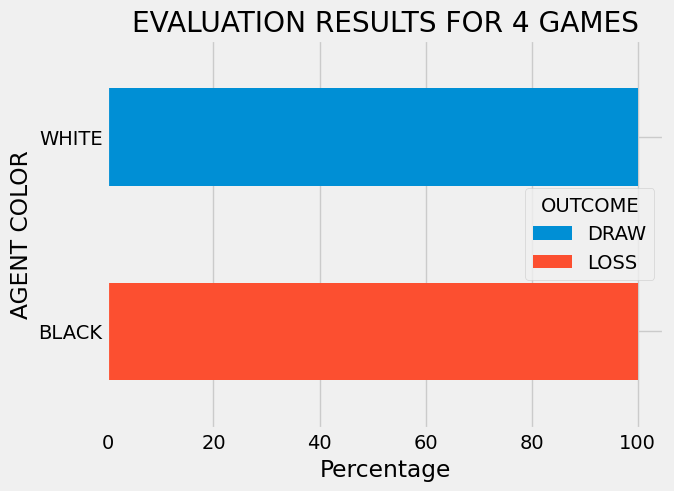

In [39]:
#number of episodes
num_episodes = 2 #200 #1000
df, WHITE_agent, BLACK_Agent= AGENT_EVALUATION(Stockfish_path, n_evaluations=num_episodes) 

In [ ]:
df.to_csv("./evaluation_data/deepsarsa.csv")
df.head(5)

In [ ]:
path_w = 'MODELS/whiteqn.pth'
path_b = 'MODELS/blackqn.pth'

# Save the trained model
torch.save(WHITE_agent.qnet.state_dict(), path_w)
torch.save(BLACK_Agent.qnet.state_dict(),path_b)

The results from the Deep SARSA were the following:


![](Images/outcome_SARSA.PNG)

# Deep Q Learning + Imitation Learning

In [40]:
#import of the games
pgn = open("C:/Users/isabe/Desktop/RL/Project/alphazero_stockfish_all/alphazero_vs_stockfish_all.pgn")

train_df=[]

for i in range(110):
    game=chess.pgn.read_game(pgn)
    # Process the moves, positions in board, rewards and outcome in the game
    moves = []
    positions = []
    rewards = []
    outcome = game.headers["Result"]
    if game.headers["White"]== "AlphaZero":
        color= "white"
    else:
        color= "black"

    board = game.board()
    for move in game.mainline_moves():
        board.push(move)
        moves.append(move)
        positions.append(board.fen())  # Save board position
        
    game_data = {
        "moves": moves,
        "positions": positions,
        "player_color": color,
        "outcome": outcome
    }

    train_df.append(game_data)



Exception ignored in: <function Stockfish.__del__ at 0x0000020063D69750>
Traceback (most recent call last):
  File "c:\Users\isabe\anaconda3\envs\week5\lib\site-packages\stockfish\models.py", line 757, in __del__
    if self._stockfish.poll() is None:
AttributeError: 'Stockfish' object has no attribute '_stockfish'


In [41]:
train_df = pd.DataFrame(train_df)
train_df.head()

,moves,positions,player_color,outcome
0,"[g1f3, g8f6, c2c4, e7e6, b1c3, f8b4, d1c2, e8g...",[rnbqkbnr/pppppppp/8/8/8/5N2/PPPPPPPP/RNBQKB1R...,white,1-0
1,"[d2d4, g8f6, c2c4, e7e6, g1f3, b7b6, g2g3, c8b...",[rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR...,white,1-0
2,"[d2d4, g8f6, c2c4, e7e6, g1f3, b7b6, g2g3, c8b...",[rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR...,white,1-0
3,"[g1f3, e7e6, c2c4, g8f6, b1c3, f8b4, d1c2, e8g...",[rnbqkbnr/pppppppp/8/8/8/5N2/PPPPPPPP/RNBQKB1R...,white,1-0
4,"[d2d4, g8f6, g1f3, e7e6, c2c4, b7b6, g2g3, c8b...",[rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR...,white,1-0


The following policies are necessary to save the moves from the games Stockfish vs. AlphaZero. For the 110 episodes, they return the step of the white or black player, respectively. 

In [42]:
def WHITE_PLAYER_POLICY(env, state, step, episode):
    encoded_move = env.encode(train_df.iloc[episode]['moves'][step])
    return encoded_move


def BLACK_PLAYER_POLICY(env, state, step, episode):
    encoded_move = env.encode(train_df.iloc[episode]['moves'][step])
    return encoded_move

In this model, we only considered the first board and the last information matrices. The state was also reshaped in order to be fed to the models.

In [43]:
def preprocess_state(state):
    state_boards= np.c_[state[:,:,:14], state[:,:,-7:]] #the state we want just has the current board and the last matrices with information
    return np.array([state_boards.reshape(8,8,21)])

The following class will be necessary to store the environment and parameter information at each step and contains the following functions:
- build_network: contains the architecture and compilation of the deep neural network used to predict the q(s,a)
- store_transition: stores the outcome of the taking an action at a specific state (state, action, reward, next_state, done)
- epsilon_greedy: with probablity epsilon, takes random action; otherwise it picks the legal action with the maximum q value predicted. 
- train: train the network (update weights)
- update_target_network: updates the target model (having 2 main and target models -> fixed q-targets, helps convergence)

In [44]:
class DQN:
    def __init__(self, state_size, env):
        #define environment
        self.env= env

        #define the state size
        self.state_size = state_size
        
        #define the action size
        self.action_size = len(env.legal_actions)
        
        #define the replay buffer
        self.replay_buffer = deque(maxlen=1000)
        
        #define the discount factor
        self.gamma = 0.9
        
        #define the epsilon value
        self.epsilon = 0.99
        
        #define the update rate at which we want to update the target network
        self.update_rate = 5
        
        #define the main network
        self.main_network = self.build_network()
        
        #define the target network
        self.target_network = self.build_network()
        
        #copy the weights of the main network to the target network
        self.target_network.set_weights(self.main_network.get_weights())

        #learning rate
        self.learning_rate = .0001
        

    #Let's define a function called build_network which is essentially our DQN. 

    def build_network(self):
        model = Sequential()
        model.add(Conv2D(filters=6, kernel_size=(7, 7), strides=1, activation='relu', padding='same', input_shape=self.state_size))
        model.add(Conv2D(filters=6, kernel_size=(3, 3), strides=2, activation='relu', padding='same'))
        model.add(Conv2D(filters=12, kernel_size=(3, 3), strides=1, activation='relu', padding='same'))
        model.add(Conv2D(filters=12, kernel_size=(3, 3), strides=2, activation='relu', padding='same'))
        model.add(Flatten())
        model.add(Dense(216, activation='relu'))
        model.add(Dense(self.env.action_space.n, activation=None))

        model.compile(loss='mse', optimizer=Adam(learning_rate=.0001, epsilon=1e-7))


        return model

    #We learned that we train DQN by randomly sampling a minibatch of transitions from the
    #replay buffer. So, we define a function called store_transition which stores the transition information
    #into the replay buffer

    def store_transition(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))
        

    #We learned that in DQN, to take care of exploration-exploitation trade off, we select action
    #using the epsilon-greedy policy. So, now we define the function called epsilon_greedy
    #for selecting action using the epsilon-greedy policy.
    def epsilon_greedy(self, state):
        if random.uniform(0,1) < self.epsilon:
            legal_actions = self.env.legal_actions
            action = np.random.choice(legal_actions)
            return action
        else:    
            Q_values = self.main_network.predict(state, verbose=0)[0]
            legal_q_values= Q_values[self.env.legal_actions]
            action= self.env.legal_actions[np.argmax(legal_q_values)]
            return action
    
    #train the network
    def train(self, batch_size):
        #get the minibatch from the replay buffer
        minibatch = np.array(random.sample(self.replay_buffer, batch_size), dtype=object)

        #states associated with the minibatch chosen
        state_list = np.array(minibatch[:,0], dtype=object)
        state_list = np.hstack(state_list).reshape(batch_size, 8, 8, 21)

        #next state associated with the minibatch states
        next_state_list = np.array(minibatch[:,3])
        next_state_list = np.hstack(next_state_list).reshape(batch_size, 8, 8, 21)

        #predict the q values, according to the states in the minibatch
        current_Q_values_list = self.main_network.predict(state_list, verbose=0)

        #get maximum q
        max_q = np.amax(self.target_network.predict(next_state_list, verbose=0), axis=1)

        #complete the q function with the formula
        for i, zip_ in enumerate(minibatch):

            state, action, reward, next_state, done = zip_

            if not done:
                target  = reward + self.gamma * max_q[i]
            else:
                target = reward

            updated_Q_value = target # (1 - self.learning_rate)*current_Q_values_list[i][action] + self.learning_rate*(target) # - current_Q_values_list[i][action]) # This is a different form of Q-learning (Min Q-Learning)

            current_Q_values_list[i][action] = updated_Q_value
        #train the main network
        self.main_network.fit(state_list, current_Q_values_list, epochs=1, verbose=0)
            
    #update the target network weights by copying from the main network
    def update_target_network(self):
        self.target_network.set_weights(self.main_network.get_weights())

The next cell generates the peisodes for white and black scenario. 

In [45]:
def generate_WHITE_scenario(Stockfish_path, dqn_white, evaluation_number):
    env = gym.make("ChessAlphaZero-v0") # We will use Alpha Zero's numenclature for the actions encodings
    stockfish = Stockfish(Stockfish_path)
    stockfish.set_elo_rating(
        100
    )  # Default "skill" level is 1350, higher will increase the skill of stockfish "player". See more at https://en.wikipedia.org/wiki/Elo_rating_system
    
    #pre-process state
    dqn_white.state = env.reset()
    dqn_white.env= env
    dqn_white.state = preprocess_state(dqn_white.state) #save state in right format
    done = False
    counter = 0  # Since each step represents a play in a chess game we are going to store the number of steps associated to the episode/game
    # set return to 0
    Return = 0 
    Real_Return = 0

    while not done:
        if (
            counter % 2 == 0
        ):  # If the step number is even, this means that it is the WHITE player's turn
            #Update target model if the correct nº episodes has passed
            if evaluation_number % dqn_white.update_rate == 0:
                dqn_white.update_target_network()

            # Select action to perform   
            action = dqn_white.epsilon_greedy(dqn_white.state)
            decoded_action = str(env.decode(action))
            stockfish.make_moves_from_current_position([decoded_action])

            # Perform selected action
            next_state, reward, done, info = dqn_white.env.step(action)
            real_reward= reward
            #pre-process next state
            next_state = preprocess_state(next_state)

            #if player removed piece from opponent, increase reward (by very small ammount). 
            # #Max reward fromo this will be 0.16 which is <<1
            if next_state[:, :,:, :6].sum() < dqn_white.state[:, :,:, :6].sum(): 
                reward += 0.01
            
            #update values in dqn class
            dqn_white.env= env

            #store the transition information
            dqn_white.store_transition(dqn_white.state, action, reward, next_state, done)

            #update current state to next state
            dqn_white.state = next_state

            #update the return
            Return += reward
            Real_Return += real_reward


        else:  # If the step number is not even, aka odd, this means that it is the BLACK player's turn
            decoded_action = stockfish.get_best_move()
            action = env.encode(chess.Move.from_uci(decoded_action))
            stockfish.make_moves_from_current_position([decoded_action])
            next_state, reward, done, info = env.step(action)

            #pre-process next state
            next_state = preprocess_state(next_state)

            #update values in dqn class
            dqn_white.env= env

            #store the transition information
            dqn_white.store_transition(dqn_white.state, action, reward, next_state, done)
            
            #update current state to next state
            dqn_white.state = next_state


        #if nº transitions in replay_buffer>batch_size
            if (len(dqn_white.replay_buffer) > batch_size) & (counter % 10 == 0): # Only train each 10 steps that the agent plays
                dqn_white.train(batch_size)

        counter += 1
        
    env.close()
    print('Episode: ',evaluation_number, ', Return:', round(reward), 'Steps:', counter, 'Epsilon:', round(dqn_white.epsilon,2))
    return reward, np.ceil(counter / 2), dqn_white.state


def generate_BLACK_scenario(Stockfish_path, dqn_black, evaluation_number):
    env = gym.make("ChessAlphaZero-v0") # We will use Alpha Zero's numenclature for the actions encodings
    stockfish = Stockfish(Stockfish_path)
    stockfish.set_elo_rating(
        100
    )  # Default "skill" level is 1350, higher will increase the skill of stockfish "player". See more at https://en.wikipedia.org/wiki/Elo_rating_system
    
    #pre-process state
    dqn_black.state = env.reset()
    dqn_black.env= env
    dqn_black.state = preprocess_state(dqn_black.state)
    done = False
    counter = 0  # Since each step represents a play in a chess game we are going to store the number of steps associated to the episode/game
    # set return to 0
    Return = 0 
    Real_Return = 0

    while not done:
        if (
            counter % 2 == 1
        ):  # If the step number is even, this means that it is the WHITE player's turn
            
            #Update target model if the correct nº episodes has passed
            if evaluation_number % dqn_black.update_rate == 0:
                dqn_black.update_target_network()

            # Select action to perform   
            action = dqn_black.epsilon_greedy(dqn_black.state)
            decoded_action = str(env.decode(action))
            stockfish.make_moves_from_current_position([decoded_action])

            # Perform selected action
            next_state, reward, done, info = dqn_black.env.step(action)
            real_reward= reward

            #pre-process next state
            next_state = preprocess_state(next_state)
            
            #if player removed piece from opponent (white players in state are 6-13), increase reward
            if next_state[:, :,:, 6:13].sum() < dqn_black.state[:, :,:, 6:13].sum(): 
                reward -= 0.01 #since -1 is black win, we assume the negative of the reward

            #update values in dqn class
            dqn_black.env= env

            #store the transition information
            #reward negative because -1 is black win, and we want it to be higher win black wins
            dqn_black.store_transition(dqn_black.state, action, -reward, next_state, done) 

            #update current state to next state
            dqn_black.state = next_state

            #update the return
            Return += reward
            Real_Return += real_reward


        else:  # If the step number is not even, aka odd, this means that it is the BLACK player's turn
            decoded_action = stockfish.get_best_move()
            action = env.encode(chess.Move.from_uci(decoded_action))
            stockfish.make_moves_from_current_position([decoded_action])
            next_state, reward, done, info = env.step(action)

            #pre-process next state
            next_state = preprocess_state(next_state)

            #update values in dqn class
            dqn_black.env= env
        
            #store the transition information
            dqn_black.store_transition(dqn_black.state, action, -reward, next_state, done)
            
            #update current state to next state
            dqn_black.state = next_state
            

        #if nº transitions in replay_buffer>batch_size
        if (len(dqn_black.replay_buffer) > batch_size) & (counter % 10 == 0): # Only train each 10 steps that the agent plays
            dqn_black.train(batch_size)

        counter += 1

    env.close()
    print('Episode: ',evaluation_number, ', Return:', round(reward), 'Steps:', counter, 'Epsilon:', round(dqn_black.epsilon,2))
    return reward, np.ceil(counter / 2), dqn_black.state

In [46]:
def AGENT_EVALUATION(Stockfish_path, n_evaluations=100): 
    results_list = []
    env= gym.make("ChessAlphaZero-v0")
    env.reset()
    dqn_white= DQN((8, 8, 21), env)
    dqn_black= DQN((8, 8, 21), env)
    for game in range(len(train_df)):
        env = gym.make(
            "ChessAlphaZero-v0"
        )  # We will use Alpha Zero's numenclature for the actions encodings
        dqn_white.state = env.reset()
        dqn_white.env= env
        dqn_white.state = preprocess_state(dqn_white.state)

        dqn_black.state = env.reset()
        dqn_black.env= env
        dqn_black.state = preprocess_state(dqn_black.state)
        
        state = env.reset()
        done = False
        counter = 0  # Since each step represents a play in a chess game we are going to store the number of steps associated to the episode/game
        while not done:
            if (
                counter % 2 == 0
            ):  # If the step number is even, this means that it is the WHITE player's turn
                #choose action according to the policy (chooses to mimic game at number)
                action = WHITE_PLAYER_POLICY(env, state, counter, game)

                #perform action
                next_state, reward, done, info = dqn_white.env.step(action)

                if counter == len(train_df.iloc[game]['moves'])-1: #last move of the game
                    done= True
                    if train_df.iloc[game]['outcome']== "1-0":
                        reward= 1
                    elif train_df.iloc[game]['outcome']== "1/2-1/2": #draw in game
                        reward= 0
                    else:
                        reward= -1
                
                #save state in the right format
                next_state = preprocess_state(next_state)

                #store the transition information
                dqn_white.store_transition(dqn_white.state, action, reward, next_state, done)

                #update current state to next state
                dqn_white.state = next_state

            else:  # If the step number is not even, aka odd, this means that it is the BLACK player's turn
                action = BLACK_PLAYER_POLICY(env, state, counter, game)

                #perform action
                next_state, reward, done, info = dqn_black.env.step(action)

                if counter == len(train_df.iloc[game]['moves'])-1: #last move of the game
                    done= True
                    if train_df.iloc[game]['outcome']== "0-1":
                        reward= 1
                    elif train_df.iloc[game]['outcome']== "1/2-1/2":
                        reward= 0
                    else:
                        reward = -1
                
                #save state in the right format
                next_state = preprocess_state(next_state)

                #store the transition information
                dqn_black.store_transition(dqn_black.state, action, -reward, next_state, done)

                #update current state to next state
                dqn_black.state = next_state

            counter += 1

        dqn_white.env.close()   
        dqn_black.env.close()          


    for evaluation_number in tqdm(range(n_evaluations)):
        #print('in white scenario')
        generate_episode = generate_WHITE_scenario
        reward, n_steps, last_state = generate_episode(Stockfish_path, dqn_white, evaluation_number)

        if reward == 1:
            result = "VICTORY"
        elif reward == 0:
            result = "DRAW"
        else:
            result = "LOSS"

        agent_pieces= last_state[:, :,:, 6:13].sum() 
        opponent_pieces= last_state[:, :,:, :6].sum() 
        remaining_pieces=[] 
        for piece in white_pieces: 
            remaining_pieces.append(last_state[:,:,:,piece].sum()) 
        results_list.append(["WHITE", result, n_steps, agent_pieces, opponent_pieces, evaluation_number, *remaining_pieces])
        
        #update the epsilon
        dqn_white.epsilon -= .005 # dqn.epsilon/num_episodes
        dqn_white.epsilon = max(dqn_white.epsilon, 0.2) 

        #print('in black scenario')
        generate_episode = generate_BLACK_scenario

        reward, n_steps, last_state = generate_episode(Stockfish_path, dqn_black, evaluation_number) 

        if reward == -1:
            result = "VICTORY"
        elif reward == 0:
            result = "DRAW"
        else:
            result = "LOSS"

        agent_pieces= last_state[:,:,:, :6].sum() 
        opponent_pieces= last_state[:, :,:, 6:13].sum() 
        remaining_pieces=[] 
        for piece in black_pieces: 
            remaining_pieces.append(last_state[:,:,:,piece].sum()) 
        results_list.append(["BLACK", result, n_steps, agent_pieces, opponent_pieces, evaluation_number, *remaining_pieces]) 

        #update the epsilon
        dqn_black.epsilon -= .005 # dqn.epsilon/num_episodes
        dqn_black.epsilon = max(dqn_black.epsilon, 0.2) 
        

    df = pd.DataFrame(
        results_list, columns=["AGENT COLOR", "OUTCOME", "N STEPS", "AGENT PIECES", "OPPONENT PIECES", "EPISODE", "pawn", "horse", "knight", "rook", "queen", "king"]  #PARA TODOS
    ).astype("int", errors="ignore")

    plt.style.use("fivethirtyeight")

    results_group = (
        df.groupby(["AGENT COLOR", "OUTCOME"])
        .count()
        .rename(columns={"N STEPS": "GAMES"})
    )

    n_games = results_group.sum()[0]

    results_group = (2 * 100 * results_group / (n_games)).astype("int")

    viz_df = (
        results_group.reset_index()
        .pivot_table(index="AGENT COLOR", columns="OUTCOME", values="GAMES")
        .fillna(0)
    )

    viz_df.plot(kind="barh", stacked=True)

    plt.xlabel("Percentage")
    plt.title(f"EVALUATION RESULTS FOR {n_games} GAMES")

    plt.show()

    return df, dqn_black, dqn_white

  0%|          | 0/5 [00:00<?, ?it/s]

Episode:  0 , Return: -1 Steps: 26 Epsilon: 0.99
Episode:  0 , Return: 1 Steps: 31 Epsilon: 0.99
Episode:  1 , Return: -1 Steps: 42 Epsilon: 0.98
Episode:  1 , Return: 1 Steps: 43 Epsilon: 0.98
Episode:  2 , Return: -1 Steps: 54 Epsilon: 0.98
Episode:  2 , Return: 1 Steps: 27 Epsilon: 0.98
Episode:  3 , Return: -1 Steps: 36 Epsilon: 0.97
Episode:  3 , Return: 1 Steps: 35 Epsilon: 0.97
Episode:  4 , Return: -1 Steps: 58 Epsilon: 0.97
Episode:  4 , Return: 1 Steps: 31 Epsilon: 0.97


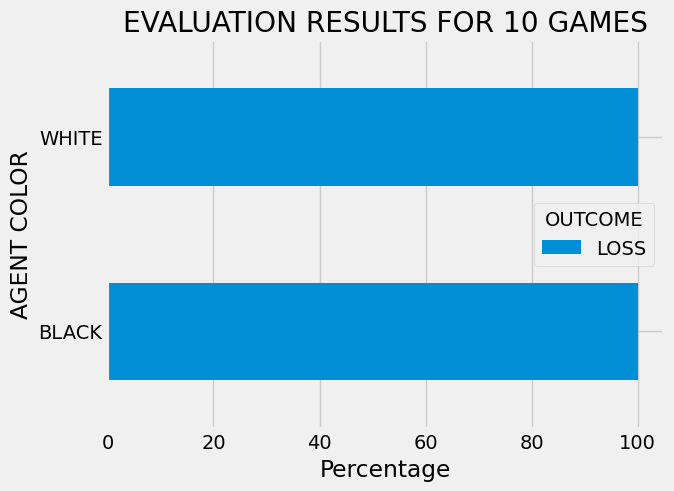

In [48]:
#number of episodes
num_episodes = 5 #800

# Define the batch size:
batch_size = 128

df, dqn_black, dqn_white = AGENT_EVALUATION(Stockfish_path, n_evaluations=num_episodes) 

In [ ]:
df.to_csv("./evaluation_data/deepqlearning_imitation.csv")
df.head(5)

In [ ]:
dqn_white.target_network.save('MODELS/target_chess_white_pretrained.keras')
dqn_white.main_network.save('MODELS/main_chess_white_pretrained.keras')
dqn_black.target_network.save('MODELS/target_chess_black_pretrained.keras')
dqn_black.main_network.save('MODELS/main_chess_black_pretrained.keras')

The results from the Deep Q Learning were the following:


![](Images/outcome_DQN.PNG)

# Evaluation